In [41]:
from scipy.stats import ks_2samp, wasserstein_distance
from Gian_experimental.NSGAIICustom.testing_in_vitro.testing_operators_in_vitro import make_metrics_cached

dir_250 = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting\250"
# dir_250 = r"/Users/gian/PycharmProjects/PSSearch/data/retail_forecasting/250"
import heapq
import itertools
import json
import random
from typing import Iterable, Optional, Iterator

import numpy as np

import utils
from Gian_experimental.NSGAIICustom.NSGAIICustom import NSGAIICustom, NCSolution, EvaluatedNCSolution, NCSampler, \
    NCMutation, NCCrossover, NCSamplerFromPRef, NCCrossoverTransition, NCSamplerSimple, NCMutationSimple, \
    NCCrossoverSimple, NCMutationCounterproductive
from Gian_experimental.NSGAIICustom.testing_in_vitro.SPRef import SPRef, OptimisedSPref
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import gian_get_similarities, get_transition_matrix
from PolishSystem.read_data import get_pRef_from_vectors
import os
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import get_transition_matrix
from typing import Iterable
from Gian_experimental.NSGAIICustom.NSGAIICustom import NSGAIICustom, NCSolution, NCSamplerSimple, NCMutationSimple, \
    NCCrossoverSimple, EvaluatedNCSolution, NCSamplerFromPRef, NCCrossoverTransition
import heapq

def in_250(path):
    return os.path.join(dir_250, path)

train_pRef = get_pRef_from_vectors(name_of_vectors_file=in_250("train_many_hot_vectors_250_qmc.csv"),
                                   name_of_fitness_file=in_250("train_fitness_250_qmc.csv"),
                                   column_in_fitness_file=2)
test_pRef = get_pRef_from_vectors(name_of_vectors_file=in_250("test_many_hot_vectors_250_qmc.csv"),
                                  name_of_fitness_file=in_250("test_fitness_250_qmc.csv"),
                                  column_in_fitness_file=2)

train_SPRef = OptimisedSPref.from_pRef(train_pRef)
test_SPRef = OptimisedSPref.from_pRef(test_pRef)

cluster_info_file_name = in_250(f"cluster_info_250_qmc.pkl")
similarities = gian_get_similarities(cluster_info_file_name)

n = 250

def keep_ones_with_most_samples(population: Iterable[EvaluatedNCSolution], quantity_required: int):
    return heapq.nsmallest(iterable=population, key=lambda x: x.fitnesses[0], n=quantity_required)

transition_matrix = get_transition_matrix(similarities)
custom_sampling = NCSamplerFromPRef.from_PRef(train_pRef)
custom_mutation = NCMutationCounterproductive(transition_matrix)
custom_crossover = NCCrossoverTransition(transition_matrix)

def atomicity(ps):
    if len(ps) < 2:
        return -1000
    else:
        linkages = [similarities[a, b] for a, b in itertools.combinations(ps, r=2)]
        return np.average(linkages)

traditional_sampling = NCSamplerSimple.with_average_quantity(3, genome_size=n)
traditional_mutation = NCMutationSimple(n)
traditional_crossover = NCCrossoverSimple(swap_probability=1 / n)




In [74]:
genome_threshold = 4

def get_metrics(ps: NCSolution) -> tuple[float]:
    # I will use sample size, variance and atomicity

    # for now, simplicity, mean fitness and atomicity
    simplicity_score = len(ps)
    matching, non_matching = train_SPRef.partition(ps, threshold=genome_threshold)
    #len_m, len_nm = len(matching), len(non_matching)
    #weighted_variance_score = (np.var(matching) * len_m + np.var(non_matching) * len_nm) / (len_m + len_nm)
    #mean_fitness = np.average(matching) if len(matching) > 0 else -1000
    #median_diff = np.median(matching) - np.median(non_matching)
    distance = wasserstein_distance(matching, non_matching) if min(len(matching), len(non_matching)) > 2 else 0
    #print(distance)
    atomicity_score = atomicity(ps)
    
    if len(matching) < 1000: # a constraint
        return 1000, 1000, 1000

    return (-len(matching), -distance)

algorithm = NSGAIICustom(sampling=traditional_sampling,
                         mutation=traditional_mutation,
                         crossover=traditional_crossover,
                         probability_of_crossover=0.5,
                         eval_budget=5000,
                         pop_size=100,
                         tournament_size=3,
                         mo_fitness_function=make_metrics_cached(get_metrics),
                         unique=True,
                         verbose=True,
                         culler=keep_ones_with_most_samples
                         )

In [75]:
results  = algorithm.run()

NSGAIICustom -> Beginning of NC process
NSGAIICustom -> Used evals: 210
NSGAIICustom -> Used evals: 316
NSGAIICustom -> Used evals: 421
NSGAIICustom -> Used evals: 529
NSGAIICustom -> Used evals: 634
NSGAIICustom -> Used evals: 744
NSGAIICustom -> Used evals: 846
NSGAIICustom -> Used evals: 950
NSGAIICustom -> Used evals: 1056
NSGAIICustom -> Used evals: 1164
NSGAIICustom -> Used evals: 1271
NSGAIICustom -> Used evals: 1381
NSGAIICustom -> Used evals: 1491
NSGAIICustom -> Used evals: 1598
NSGAIICustom -> Used evals: 1707
NSGAIICustom -> Used evals: 1817
NSGAIICustom -> Used evals: 1924
NSGAIICustom -> Used evals: 2036
NSGAIICustom -> Used evals: 2144
NSGAIICustom -> Used evals: 2257
NSGAIICustom -> Used evals: 2363
NSGAIICustom -> Used evals: 2474
NSGAIICustom -> Used evals: 2585
NSGAIICustom -> Used evals: 2697
NSGAIICustom -> Used evals: 2807
NSGAIICustom -> Used evals: 2919
NSGAIICustom -> Used evals: 3028
NSGAIICustom -> Used evals: 3133
NSGAIICustom -> Used evals: 3245
NSGAIICusto

In [76]:
print(f"There are {len(results)} results")

for result in results:
    print(result.fitnesses, len(result.solution))

There are 70 results
(-7894, -0.4388945732464248) 68
(-5290, -0.6064315799271236) 55
(-7358, -0.4530665546769942) 67
(-6827, -0.4721255362802165) 65
(-3497, -0.7949795880738499) 42
(-7474, -0.44925533232898807) 67
(-2000, -0.9696581446737921) 32
(-3346, -0.8153793490231015) 41
(-3531, -0.7770180087458367) 42
(-4266, -0.6964609258828895) 50
(-3834, -0.7675966522209188) 45
(-2429, -0.8848063139762331) 36
(-5904, -0.5549519022822764) 58
(-7165, -0.4671293650319733) 66
(-5760, -0.5758005579293826) 58
(-6814, -0.47479074625829254) 64
(-3217, -0.8411721473694918) 40
(-4676, -0.6435247572775109) 52
(-2296, -0.9006683648561922) 36
(-4667, -0.6519828651861787) 53
(-4261, -0.6983707585217225) 49
(-2547, -0.8495217786792035) 39
(-1152, -1.193288798498361) 25
(-7270, -0.459434506642168) 66
(-5045, -0.6225683552835339) 53
(-3063, -0.8422371557515236) 39
(-6532, -0.49701000303032017) 61
(-4580, -0.6616052947053384) 50
(-5144, -0.617803404414534) 55
(-1697, -1.0432792693170843) 30
(-7346, -0.45517366

In [79]:


from matplotlib import pyplot as plt
from Gian_experimental.plotting_utils import display_side_by_side

def compare_histograms(
    data1,
    data2,
    bins=30,
    log_x=False,
    log_y=False,
    labels=("Data 1", "Data 2"),
    title="Histogram Comparison",
    figsize=(6, 4),
    ax=None,
    y_axis_frequency="absolute",  # "absolute" or "relative"
):
    """
    Creates a histogram comparison plot of two datasets on a given Axes or a new figure.

    Parameters:
        ...
        y_axis_frequency (str): "absolute" for counts, "relative" for percentages (0–100%).

    Returns:
        matplotlib.figure.Figure or None
    """
    data1 = np.array(data1)
    data2 = np.array(data2)

    if log_x:
        data1 = data1[data1 > 0]
        data2 = data2[data2 > 0]
        combined = np.concatenate([data1, data2])
        min_val = combined.min()
        max_val = combined.max()
        bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None

    density = y_axis_frequency == "relative"

    ax.hist(data1, bins=bins, alpha=0.5, label=labels[0], edgecolor='black', density=density)
    ax.hist(data2, bins=bins, alpha=0.5, label=labels[1], edgecolor='black', density=density)

    if log_x:
        ax.set_xscale('log')
    if log_y:
        ax.set_yscale('log')

    ax.set_xlabel("Value")
    ax.set_ylabel("Percentage" if density else "Frequency")

    if density:
        # Convert y-axis to percentage
        ticks = ax.get_yticks()
        ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])

    ax.set_title(title)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    return fig

def display_side_by_side(histogram_args_list, figsize_per_plot=(5, 5)):
    """
    Displays multiple histograms side-by-side using `compare_histograms`.

    Parameters:
        histogram_args_list (list[dict]): Each dict contains args for `compare_histograms`.
        figsize_per_plot (tuple): Size per individual plot; used to scale total figure.
    """
    num = len(histogram_args_list)
    total_figsize = (figsize_per_plot[0] * num, figsize_per_plot[1])
    fig, axs = plt.subplots(1, num, figsize=total_figsize)

    if num == 1:
        axs = [axs]  # Ensure it's iterable

    for args, ax in zip(histogram_args_list, axs):
        compare_histograms(ax=ax, **args)

    plt.tight_layout()
    plt.show()


def get_textual_description_of_distribution(values):
    return (f"n = {len(values)},\n"
              f"average = {np.average(values):.2f}, median = {np.median(values):.2f}\n"
              f"min = {np.min(values):.2f}, max = {np.max(values):.2f},\n")

def make_ps_into_explanation(ps, genome_threshold, test_SPref: SPRef):
    print(f"If you match at least {genome_threshold} items from this list of {len(ps)}:")
    print(ps)
    
    match_fitnesses, match_non_fitnesses = test_SPref.partition_using_threshold(ps, genome_threshold)
    distance = wasserstein_distance(match_fitnesses, match_non_fitnesses)
    if len(match_fitnesses) < 100:
        print("There are not enough matches!!!")
        return
    all_fitnesses = test_SPref.fitnesses
    
    print(f"The Wasserstein distance is {distance}")
    print("Distribution of match fitness")
    print(utils.indent(get_textual_description_of_distribution(match_fitnesses)))
    print("Distribution of match fitness")
    print(utils.indent(get_textual_description_of_distribution(match_non_fitnesses)))
    
    display_side_by_side([
            {
                "data1": match_fitnesses,
                "data2": match_non_fitnesses,
                "title": f"Fitnesses of matches vs non-matches",
                "labels": ("Matches", "Non matches"),
                "y_axis_frequency": "relative"
            },
            {
                "data1": match_fitnesses,
                "data2": all_fitnesses,
                "title": f"Fitnesses of matches vs all",
                "labels": ("Matches", "All"),
                "y_axis_frequency": "relative"
            }
        ])

The metrics were (-1152, -1.193288798498361)
If you match at least 4 items from this list of 25:
{64, 67, 68, 133, 70, 11, 15, 82, 151, 216, 218, 33, 164, 229, 233, 173, 174, 237, 48, 178, 183, 120, 123, 188, 126}
Distribution of match fitness
	n = 487,
	average = 4.26, median = 4.04
	min = -5.08, max = 19.10,
	
Distribution of match fitness
	n = 15345,
	average = 3.50, median = 3.26
	min = -7.22, max = 15.66,
	


C:\Users\gac8\AppData\Local\Temp\ipykernel_12332\772801009.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])


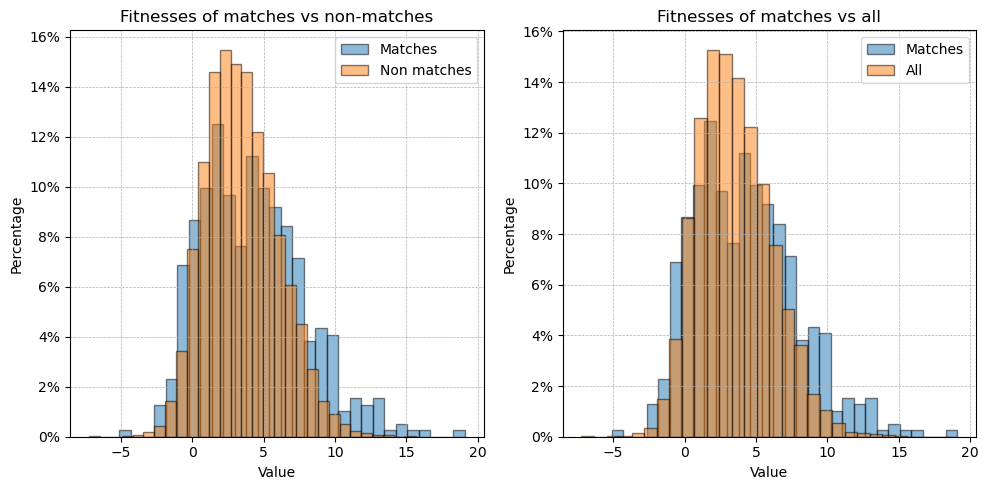

The metrics were (-1155, -1.1370796769494493)
If you match at least 4 items from this list of 24:
{64, 67, 68, 133, 70, 11, 15, 82, 151, 218, 225, 164, 229, 233, 173, 174, 237, 48, 178, 183, 120, 123, 188, 126}
Distribution of match fitness
	n = 487,
	average = 3.98, median = 3.66
	min = -5.08, max = 16.60,
	
Distribution of match fitness
	n = 15345,
	average = 3.50, median = 3.27
	min = -7.22, max = 19.10,
	


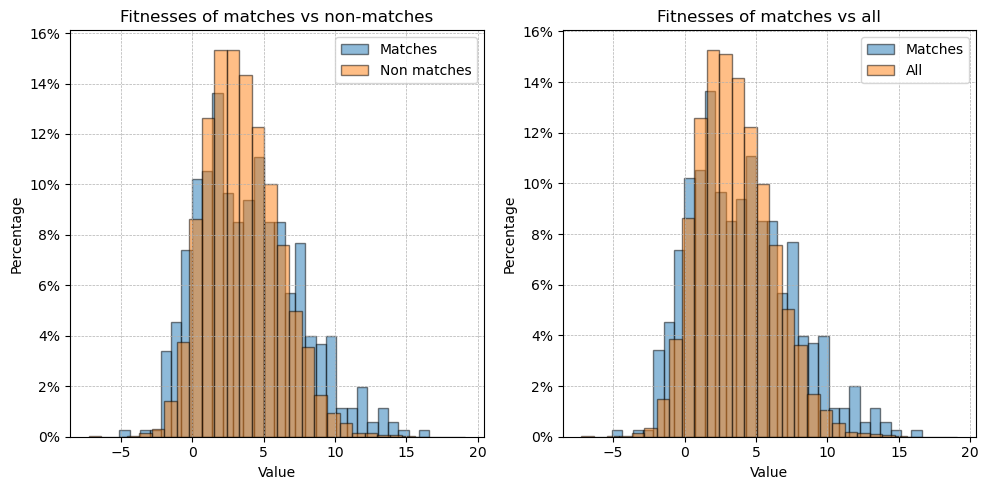

The metrics were (-1288, -1.121144280767453)
If you match at least 4 items from this list of 26:
{64, 67, 68, 133, 70, 11, 15, 82, 151, 216, 218, 225, 33, 164, 229, 233, 173, 174, 237, 48, 178, 183, 120, 123, 188, 126}
Distribution of match fitness
	n = 548,
	average = 4.07, median = 3.78
	min = -5.08, max = 19.10,
	
Distribution of match fitness
	n = 15284,
	average = 3.50, median = 3.27
	min = -7.22, max = 15.66,
	


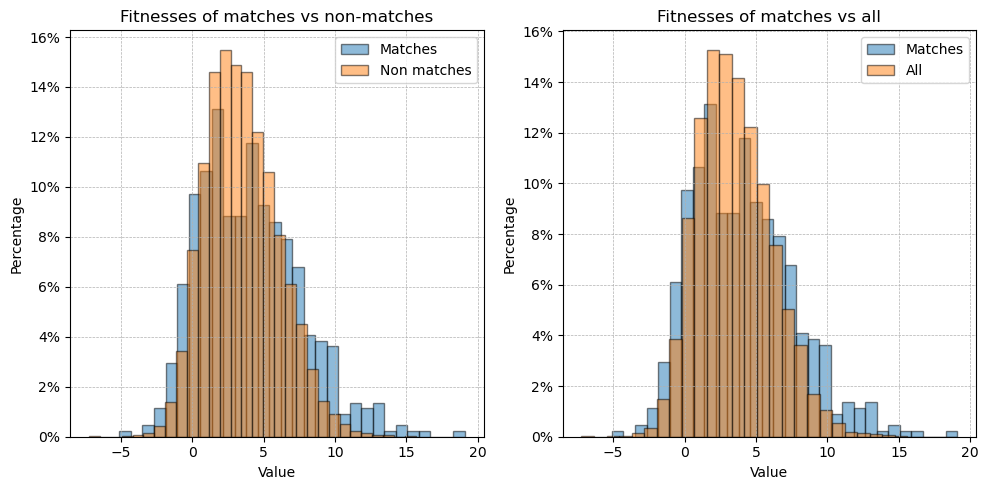

In [80]:
for result in sorted(results, key=lambda x: x.fitnesses[1])[:3]:
    print(f"The metrics were {result.fitnesses}")
    make_ps_into_explanation(result.solution, genome_threshold=genome_threshold, test_SPref=test_SPRef)

0.18002582026925235
0.979539288936408
2.29523504859582
